# About
Demos of the following dimensionality reduction techniques:

1. PCA
1. t-SNE

**Disclaimer: I did not clean up this notebook too much so if you half run early cells and skip ahead things might break. Just rerun from the top again if needed**

## PCA

In [117]:
import os
import pandas as pd
import tools
import numpy as np
import matplotlib as mpl
from matplotlib import pyplot as plt
from matplotlib import rc
plt.style.use('seaborn-poster')
mpl.rcParams['font.family'] = 'serif'
%matplotlib notebook

pd.set_option('display.height', 500)
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)

height has been deprecated.



In [118]:
def format_zipcode(z):
    try:
        fz = int(float(z))
        if len(str(fz)) != 5:
            return False
        else:
            return True
    except ValueError:
        return False
# listings[listings['zipcode'].apply(lambda z: format_zipcode(z))]

data_folder = '../../data/'
zipdata = pd.read_csv(data_folder + 'demand_dimensions.csv')
zipdata_venue= pd.read_csv(data_folder + 'nightlife_zip_counts.csv')
zipdata_venue[zipdata_venue['zipcode'].apply(lambda z: format_zipcode(z))]
# zipdata_venue['zipcode'].head(100)
# zipdata_cut.join(zipdata_venue, 'zipcode')
# i=0
# for zipcode in zipdata_cut['zipcode']:
#     if zipcode in zipdata_venue['zipcode']:
#         pass
#     else:
#         print(zipcode,'not found')
#         i = i +1
# print (i)       
# # pd.join(zipdata['zipcode'],zipdata_venue,zipdata)
quintiles = zipdata['airbnb_density'].describe()
zipdata_cut=zipdata[zipdata['airbnb_density'] >= quintiles['25%']]
zipdata_cut.head()
# zipdata_cut['zipcode'].head()

,zipcode,airbnb_density,airbnb_avg_price,households,airbnb_10khousehold,gini_score,ZRI,median_household_income
47,90044,15,131.866667,26326,0.569778926,0.224141,2170.500000,41110
53,90280,16,71.250000,23398,0.68381913,0.192765,2162.055556,128184
55,91331,16,84.812500,22406,0.714094439,0.190224,2354.222222,58502
57,90011,17,123.411765,22734,0.747778658,0.209742,2221.277778,45786
59,93550,16,60.062500,20648,0.774893452,0.215865,1497.555556,57202


In [119]:
# # Extract numeric data
# usable_listings = zipdata_cut.select_dtypes(include = [np.number]).dropna(axis = 1, how = 'all')
# usable_listings.fillna(value=0, inplace=True)

In [120]:
gini_mean=zipdata_cut['gini_score'].mean(skipna=True)
zipdata_cut_1=zipdata_cut.copy()
tmp = zipdata_cut_1['gini_score']
tmp = tmp.fillna(gini_mean)
# print(tmp)
zipdata_cut['gini_score'] = tmp


ZRI_mean=zipdata_cut['ZRI'].mean(skipna=True)
zipdata_cut_2=zipdata_cut.copy()
tmp = zipdata_cut_2['ZRI']
tmp = tmp.fillna(ZRI_mean)
# print(tmp)
zipdata_cut['ZRI'] = tmp

/Users/Pengji/miniconda2/envs/work_py3/lib/python3.5/site-packages/ipykernel/__main__.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/Users/Pengji/miniconda2/envs/work_py3/lib/python3.5/site-packages/ipykernel/__main__.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


In [121]:
zipdata_cut.dtypes

zipcode                      int64
airbnb_density               int64
airbnb_avg_price           float64
households                   int64
airbnb_10khousehold         object
gini_score                 float64
ZRI                        float64
median_household_income     object
dtype: object

In [122]:
# pd.set_option('display.height', 500)
# pd.set_option('display.max_rows', 500)
# listings.columns

Treating the review score as the "class".
Normally you'd want something more truly discrete as the class variable but this should be sufficiently illustrative.
To get a reasonable set of labels, we can group the scores by quartiles and use that.

In [123]:
# zipdata_cut['airbnb_10khousehold']
zipdata_cut['airbnb_10khousehold'] = pd.to_numeric(zipdata_cut['airbnb_10khousehold'])
stats = zipdata_cut['airbnb_10khousehold'].describe()
print(stats)

def classify(row):
    if row['airbnb_10khousehold'] <= stats['25%']:
        return "few"
    elif row['airbnb_10khousehold'] > stats['25%'] and row['airbnb_10khousehold'] < stats['50%']:
        return "less popular"
    elif row['airbnb_10khousehold'] > stats['50%'] and row['airbnb_10khousehold'] < stats['75%']:
        return "popular"
    elif row['airbnb_10khousehold'] >= stats['75%']:
        return "most popular"

class_col = 'PCA_class'
y = zipdata_cut.apply(lambda row: classify(row), axis = 1)


# airbnb_density	airbnb_avg_price	households
zipdata_cut=zipdata_cut.drop(['airbnb_density','households'], axis=1)

count    304.000000
mean      15.999660
std       25.052244
min        0.569779
25%        3.221026
50%        7.620922
75%       17.428199
max      226.907631
Name: airbnb_10khousehold, dtype: float64


/Users/Pengji/miniconda2/envs/work_py3/lib/python3.5/site-packages/ipykernel/__main__.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  from ipykernel import kernelapp as app


### Standardization
In order for PCA to give meaningful results we need to scale the data so that it's reasonably comparable.
Otherwise the absolute variation won't necessarily be comparable as a measure of dataset variance.

In [124]:
from sklearn.preprocessing import StandardScaler
X_standardized = StandardScaler().fit_transform(zipdata_cut)

### Apply PCA
Use sklearn.decomposition.PCA

In [125]:
from sklearn.decomposition import PCA
num_comp = 6 # The number of principal components to include
pca = PCA(n_components = num_comp)
y_est = pca.fit_transform(X_standardized)

<IPython.core.display.Javascript object>


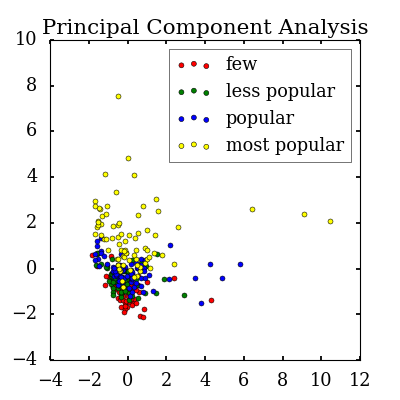

In [138]:
# fig, ax = plt.subplots(1, 1)
# # for lab in y.unique():
# p = ax.scatter(y_est[:, 0], y_est[:, 1])
# ax.legend()

fig, ax = plt.subplots(1, 1, figsize = (5, 5))
color=['r','g','b','yellow']
i=0
for lab in y.unique():
    p = ax.scatter(y_est[y==lab, 0], y_est[y==lab, 1], label=lab,c=color[i])
    i+=1
ax.legend()
ax.set_title('Principal Component Analysis')

plt.savefig('PCA.png')

### Try different splits
Evidently the bottom quartile is terrible and can be separated this way.
We can try pruning further to get a better picture of the other clusters, which are currently still very close together.

Apparently in this case PCA primarily helps identify the bad spots.
Relatively unsurprising since people on AirBnB probably give good ratings to anything decent.
Therefore, we might need a better way to label our data.
However, going back to the original PCA it would be helpful to at least identify which features are contributing most to each component, i.e. what is causing the variance in a particular component.
We can do so as below.

In [129]:
print(pca.explained_variance_ratio_[0])
sorted(zip(pca.components_[0], zipdata_cut.columns), key= lambda x: abs(x[0]), reverse = True)

0.305201157171


[(0.66492159547575103, 'ZRI'),
 (0.57451118979587135, 'airbnb_avg_price'),
 (-0.40914289579594121, 'gini_score'),
 (0.23565304248491351, 'zipcode'),
 (0.051235191707872586, 'median_household_income'),
 (0.047548440429592588, 'airbnb_10khousehold')]

In [130]:
print(pca.explained_variance_ratio_[1])
sorted(zip(pca.components_[1], zipdata_cut.columns), key= lambda x: abs(x[0]), reverse = True)

0.234542671628


[(0.70872577392891134, 'airbnb_10khousehold'),
 (0.45689439402076087, 'gini_score'),
 (0.34779410777387704, 'airbnb_avg_price'),
 (-0.33811158832468874, 'zipcode'),
 (-0.22181716067363452, 'median_household_income'),
 (0.066874881310419562, 'ZRI')]

The first principal component is rather boring, since it basically just says tells us again that the classes are based on reviews.
The second principal component is a little more interesting, since it at least tells us that availability is critical.
Also, both components correlate with how many listings the host has; someone who has multiple listings tends to be more experienced and do a better job.
Finally, it could be helpful to see how useful each component is; for this it is worth looking at a larger set of components to understand how big the dropoff is.

In [106]:
num_comp = 8
pca = PCA(n_components = num_comp)
y_est = pca.fit_transform(X_standardized)
pca.explained_variance_ratio_

array([ 0.26863264,  0.15416249,  0.10981693,  0.07459985,  0.05954989,
        0.0519828 ,  0.03929117,  0.035376  ])

After the first component, there is some signficiant dropoff, but at least the first 3-4 components appear significant enough to be worth investigating.

## t-SNE
Note that t-SNE is very slow, and is therefore likely to not be worth running for larger datasets.
A standard practice is to use PCA to reduce the dataset first.

In [108]:
from sklearn.manifold import TSNE
num_comp = 2 # The number of principal components to include
tsne = TSNE(n_components = num_comp, verbose=1)
tsne_y_est = tsne.fit_transform(X_standardized)

[t-SNE] Computing pairwise distances...
[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Computed conditional probabilities for sample 1000 / 4870
[t-SNE] Computed conditional probabilities for sample 2000 / 4870
[t-SNE] Computed conditional probabilities for sample 3000 / 4870
[t-SNE] Computed conditional probabilities for sample 4000 / 4870
[t-SNE] Computed conditional probabilities for sample 4870 / 4870
[t-SNE] Mean sigma: 1.026655
[t-SNE] KL divergence after 100 iterations with early exaggeration: 1.556478
[t-SNE] Error after 325 iterations: 1.556478


<IPython.core.display.Javascript object>


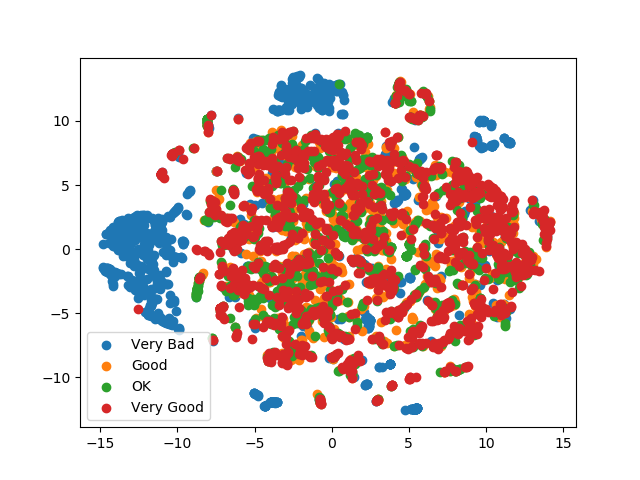

In [109]:
fig, ax = plt.subplots(1, 1)
for lab in y.unique():
    p = ax.scatter(tsne_y_est[y==lab, 0], tsne_y_est[y==lab, 1], label=lab)
ax.legend()

To actually run t-SNE on PCA reduced data, we need to compute the principal components, project into this new basis, and then perform dimensionality reduction on this new basis.

In [110]:
num_comp = 20
pca = PCA(n_components = num_comp)
y_est = pca.fit_transform(X_standardized)

num_comp = 2
tsne_pca = TSNE(n_components = num_comp, verbose=1)
tsne_pca_y_est = tsne_pca.fit_transform(y_est)


[t-SNE] Computing pairwise distances...
[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Computed conditional probabilities for sample 1000 / 4870
[t-SNE] Computed conditional probabilities for sample 2000 / 4870
[t-SNE] Computed conditional probabilities for sample 3000 / 4870
[t-SNE] Computed conditional probabilities for sample 4000 / 4870
[t-SNE] Computed conditional probabilities for sample 4870 / 4870
[t-SNE] Mean sigma: 1.018468
[t-SNE] KL divergence after 100 iterations with early exaggeration: 1.551911
[t-SNE] Error after 450 iterations: 1.551911


<IPython.core.display.Javascript object>


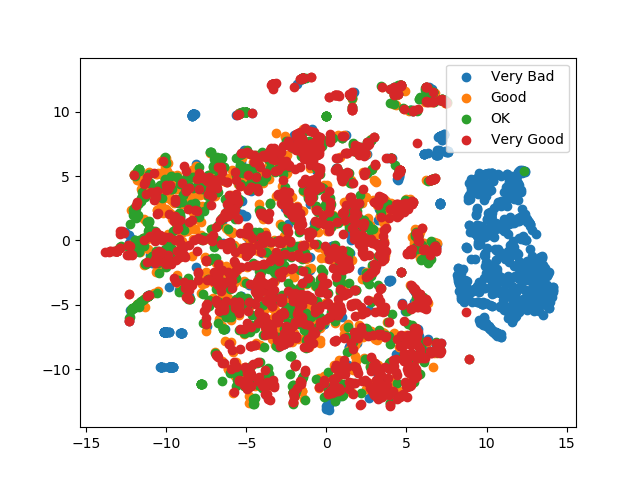

In [111]:
fig, ax = plt.subplots(1, 1)
for lab in y.unique():
    p = ax.scatter(tsne_pca_y_est[y==lab, 0], tsne_pca_y_est[y==lab, 1], label=lab)
ax.legend()

In all cases, we see again that both of these dimensionality reduction techniques basically just serve to weed out the very bad AirBnBs.
To do a better job, we'll need to try out different classifiers.